In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

D:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
D:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [11]:
def load_data(path):
    # action
    test_action = pd.read_csv(path + "test/test_actions.csv",delimiter="\t")
    train_action = pd.read_csv(path + "train/train_actions.csv",delimiter="\t")
    action = pd.concat([test_action,train_action])
    
    # info
    test_info = pd.read_csv(path + "test/test_info.csv", delimiter="\t")
    train_info = pd.read_csv(path + "train/train_info.csv", delimiter="\t")
    info = pd.concat([test_info,train_info])
    
    #flag
    test_flag = pd.read_csv(path + "submit_example.csv", delimiter="\t")
    train_flag = pd.read_csv(path + "train/train_flag.csv", delimiter="\t")
    test_flag["FLAG"] = -1
    flag = pd.concat([train_flag, test_flag])
    
    return info,action,flag

# 读取数据

In [13]:
print("加载数据...")
path = "../data/"
info, action, flag = load_data(path)
print("数据加载完成...")
print("合并基本用户特征和标签")
data = pd.merge(info, flag, on=["USRID"], how="left")
print("合并完成")

加载数据...
数据加载完成...
合并基本用户特征和标签
合并完成


# 训练集&测试集切分

In [16]:
train = data[data["FLAG"] != -1]
test = data[data["FLAG"] == -1]
print("train", train.shape)
print("test", test.shape)

train (56000, 32)
test (24000, 32)


# 取出特征列和标签

In [18]:
# 构造数据
# userid取出
train_userid = train.pop("USRID")
# 取出标签y
y = train.pop("FLAG")
y = y.values
# 取出特征名
col = list(train.columns)
# 取出训练集特征数据
X = train.values
print(X.shape)
print(len(col))
test_userid = test.pop("USRID")
test_y = test.pop("FLAG")
test = test.values

(56000, 30)
30


# 建模与预估

In [24]:
# 拟合
gbm = lgb.LGBMClassifier()
gbm.fit(train, y)

# 预估和产出结果文件
res = pd.DataFrame()
res["USRID"] = test_userid
res["FLAG"] = gbm.predict_proba(test)[:,1]

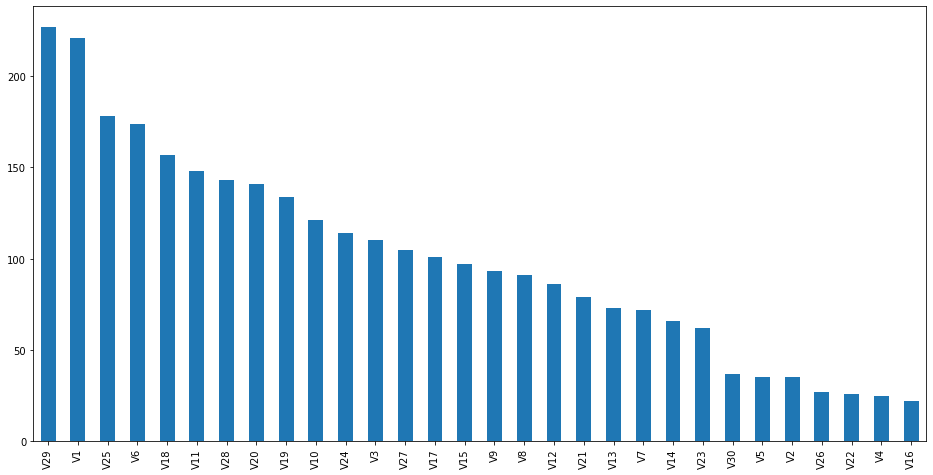

In [38]:
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 16, 8
feature_importances = gbm.feature_importances_
# indexs = np.argsort(feature_importances)[::-1]
feat_importances = pd.Series(feature_importances, index=col)
feat_importances.sort_values(ascending = False).plot(kind="bar")